# Selection de modèle
Notes et réflexions à la 

lecture du chapitre _7. Model Assessment and Selection_ du livre _The Elements of Statistical Learning
Data Mining, Inference, and Prediction_ (Trevor Hastie, Robert Tibshirani, Jerome Friedman)

## Le risque du surapprentissage (over-fitting) 
* Données d'apprentissage &#8800; Données d'utilisation

* Avec un modèle suffisament complexe la prediction peut devenir très bonne -sur les données d'apprentisage-, mais mauvaise sur les données "réelles"... le modèle ne supporte pas la généralisation

 ... a un certain point, on modélise le bruit de la mesure

* il y a l'erreur irreductible $\epsilon$ -le bruit-, et l'erreur dans l'estimation du modèle $E\!\left( f - \hat f \right)$

Remarques: C'est un problème que l'on ne rencontre pas forcement en "physique" parce que chaque paramètres se doit d'avoir une signification physique... et on essaye d'avoir le modèle minimal permettant d'expliquer les faits observés (Rasoir d'Ockham) 

On peut citer cette phrase attribuée à John von Neumann:

    With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.
    
(et c'est possible: https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/ )


    Unfortunately training error is not a good estimate of the test error [...].
    Training error consistently decreases with model
    complexity, typically dropping to zero if we increase the model complexity
    enough. However, a model with zero training error is overfit to the training
    data and will typically generalize poorly.
    

 
 * Utilisation de 3 jeux de données: Train / Validation / Test
 
 ... deux cas de figures: beaucoup de données, pas beaucoup de données

## Illustration 

In [71]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# Theorie:
f = lambda x: 4*np.sin( x*12 ) + 15*x
# Mesure:
fm = lambda x: f(x) + np.random.normal(loc=0.0, scale=1.0, size=len(x))

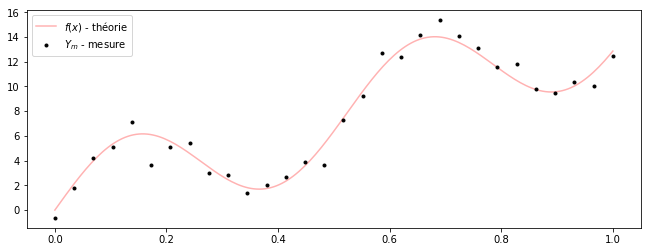

In [73]:
X = np.linspace(0, 1, 200)
Y = f(X)

Xm = np.linspace(0, 1, 30)
Ym = fm(Xm)

plt.figure( figsize=(11, 4) )
plt.plot( X, Y, "-r", alpha=.3, label='$f(x)$ - théorie' );
plt.plot( Xm, Ym, ".k",  label='$Y_m$ - mesure' );
plt.legend( loc=2 );

### Construction d'un modèle
utilisation de fonction spline pour lisser les données mesurées. Le nombre de paramètres ajustables du modèles est à la fois le nombre de points (knot) et le dégrée des courbes utilisées (polynôme).

Par simplicité on se restreint ici à une spline de dégrée 1, c'est-à-dire un ligne brisée, ou linéaire par morceau. Le nombre de paramètres est alors simplement le nombre de points (le nombre d'intervalles plus un. Une spline de degrée 2 (ou mieux 3), est en réalité plus intéressante parce qu'elle respecte la continuité de la dérivée première (et seconde).

In [74]:
from scipy.interpolate import LSQUnivariateSpline as Spline

[doc LSQUnivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LSQUnivariateSpline.html#scipy.interpolate.LSQUnivariateSpline)

In [75]:
def get_model( Xm, Ym,  n=10 ):
    # n = 10 , nombre de points 
    t = np.linspace( 0, 1, n )[1:-1]
    S = Spline( Xm, Ym, t, w=None, bbox=[None, None], k=1, ext=0, check_finite=False)
    return S

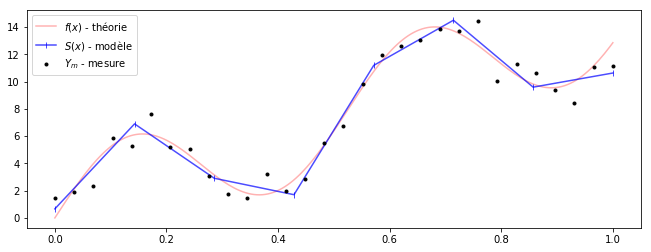

In [77]:
# Mesure:
Ym = fm(Xm)

# Modele (spline):
S = get_model( Xm, Ym,  n=8 )
Xs = S.get_knots()
Ys = S(S.get_knots())

plt.figure( figsize=(11, 4) )
plt.plot( X, f(X), "-r", alpha=.3, label='$f(x)$ - théorie' );
plt.plot( S.get_knots(), S(S.get_knots()), "-|b",  alpha=.7, label='$S(x)$ - modèle' );
plt.plot( Xm, Ym, ".k",  label='$Y_m$ - mesure' );
plt.legend( loc=2);


Le modèle obtenue dépend des points utilisé pour l'ajuster. Si nous avons la possibilité de réaliser un grand nombre de serie de mesure, et pour chacune ajuster un modèle,  

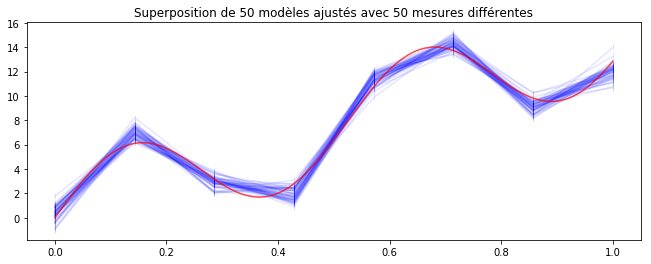

In [78]:
plt.figure( figsize=(11, 4) )
Xm = np.linspace(0, 1, 60)
for i in range(50):
    # Mesure:
    Ym = fm(Xm)

    # Modele (spline):
    S = get_model( Xm, Ym,  n=8 )
    Xs = S.get_knots()
    Ys = S(S.get_knots())


    plt.plot( S.get_knots(), S(S.get_knots()), "-|b",  alpha=.1, label='$S(x)$ - modèle' );
    #plt.plot( Xm, Ym, ".k",  label='$Y_m$ - mesure' );
plt.plot( X, f(X), "-r", alpha=.7, label='$f(x)$ - théorie' );
plt.title('Superposition de 50 modèles ajustés avec 50 mesures différentes');

Rq: Il y a pleins de paramètres... nombre de points de mesure, nombre de points du modèle, 

Même pour une mesure sans bruit, un modèle trop simple ne refletera pas la réalité... de même pour un modèle complexe avec peu de points de mesure

Il y a 4 fréquences caractéristiques, par ordre croissant:
* fréquence du signal utile
* fréquence de modélisation (complexité du modèle)
* fréquence d'échantillonage, (c.a.d. de mesure)
* fréquence du bruit (infini, si bruit blanc)

On peut se poser la question sans considérer le bruit: quelle est la fréquence du modèle pour representer 'correctement' la courbe théorique ? Ce n'est qu'une fréquence minimal si il n'y a pas de bruit. C'est aussi une borne supérieure si un bruit (haute fréquence) est présent.

* C'est quoi le même raisonement avec des données qualitative ? Titanic, avec les feuilles de l'arbre de decision n'ayant qu'un ou deux points d'aprentissage ?

## Considération plus simple

le modèle

In [79]:
def get_model_simple( f,  n=10 ):
    Xm = np.linspace(0, 1, 500)
    t = np.linspace( 0, 1, n )[1:-1]
    S = Spline( Xm, f(Xm), t, w=None, bbox=[None, None], k=1, ext=0, check_finite=False)
    return S
    return I

In [80]:
# Theorie:
f = lambda x: 4*np.sin( x*12 ) + 15*x**2

In [103]:
# Modele :
I = get_model_simple( f,  n=24 )

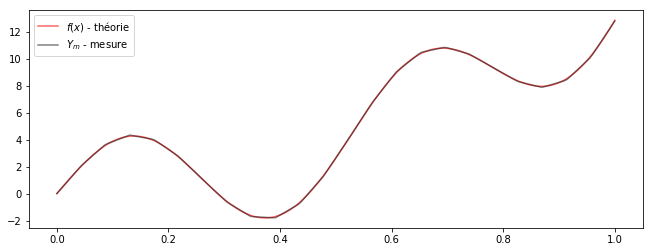

In [104]:
X = np.linspace(0, 1, 200)

plt.figure( figsize=(11, 4) )
plt.plot( X, f(X), "-r", alpha=.6, label='$f(x)$ - théorie' );
plt.plot( X, I(X), "-k", alpha=.5, label='$Y_m$ - mesure' );
plt.legend( loc=2 );

In [105]:
E, Em = [], []
for n in range(2, 60):
    I = get_model_simple( f,  n=n )
    
    Xm = np.linspace(0, 1, 500)
    residus = ( f(Xm) - I(Xm) )
    E.append( np.std(residus) )
    
    I = get_model_simple( fm,  n=n )
    Xm = np.linspace(0, 1, 500)
    residus = ( f(Xm) - I(Xm) )
    Em.append( np.std(residus) )

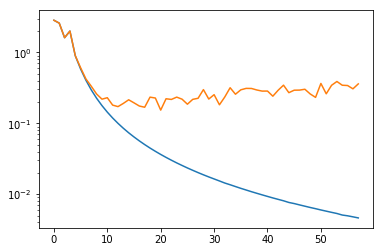

In [106]:
plt.semilogy(E)
plt.semilogy(Em)

Il nous faut une mesure, une échelle, pour pouvoir estimer si le modèle est acceptable. Un critère peut être de reduire par 100 l'amplitudes des résidus (l'écart-type).